In [14]:
import json
import numpy as np

import sys
sys.path.insert(1, '../../GillesPy2/')
import gillespy2
from gillespy2 import Model, Species, Parameter, Reaction, Event, \
                      EventTrigger, EventAssignment, RateRule, \
                      AssignmentRule, FunctionDefinition, export_StochSS
from gillespy2 import TauHybridSolver

import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, interactive_output
import ipywidgets as widgets
from IPython.display import display

# Devils DFTD Vaccination Parameter Sweep

## Model

In [2]:
variables = {
    "vaccinated_infection_rate": "0.5",
    "vaccination_proportion": "0.6",
    "vaccine_frequency": "3",
    "vaccine_time": "0",
    "program_length": "4"
}

In [3]:
class DevilsDFTDVaccination(Model):
    def __init__(self, values=None):
        Model.__init__(self, name="Devils Vaccination")
        self.volume = 1

        # Parameters
        birth_rate = Parameter(name="birth_rate", expression="0.029")
        carrying_capacity = Parameter(name="carrying_capacity", expression="61874.126205199995")
        death_rate_susceptible = Parameter(name="death_rate_susceptible", expression="0.0048")
        death_rate_infected = Parameter(name="death_rate_infected", expression="0.044")
        latency = Parameter(name="latency", expression="27.39")
        vaccinated_infection_rate = Parameter(name="vaccinated_infection_rate",
                                              expression=values['vaccinated_infection_rate'])
        vaccination_proportion = Parameter(name="vaccination_proportion",
                                           expression=values['vaccination_proportion'])
        vaccine_frequency = Parameter(name="vaccine_frequency", expression=values['vaccine_frequency'])
        vaccine_time = Parameter(name="vaccine_time", expression=values['vaccine_time'])
        program_length = Parameter(name="program_length", expression=values['program_length'])
        infection_rate = Parameter(name="infection_rate", expression="0.48")
        self.add_parameter([birth_rate, carrying_capacity, death_rate_susceptible, death_rate_infected,
                            latency, vaccinated_infection_rate, vaccination_proportion, vaccine_frequency,
                            vaccine_time, program_length, infection_rate])

        # Variables
        Susceptible = Species(name="Susceptible", initial_value=34616, mode="discrete")
        Exposed = Species(name="Exposed", initial_value=0, mode="discrete")
        Infected = Species(name="Infected", initial_value=0, mode="discrete")
        Devils = Species(name="Devils", initial_value=34616, mode="discrete")
        Vaccinated = Species(name="Vaccinated", initial_value=0, mode="discrete")
        self.add_species([Susceptible, Exposed, Infected, Devils, Vaccinated])

        # Reactions
        Birth = Reaction(name="Birth",
            reactants={}, products={'Susceptible': 1, 'Devils': 1},
            propensity_function="birth_rate*(Susceptible+Exposed+Infected+Vaccinated)*\
                                 (1-(Susceptible+Exposed+Infected+Vaccinated)/carrying_capacity)"
        )
        Death_Susceptible = Reaction(name="Death_Susceptible",
            reactants={'Susceptible': 1, 'Devils': 1}, products={},
            propensity_function="death_rate_susceptible*Susceptible"
        )
        Transmission = Reaction(name="Transmission",
            reactants={'Susceptible': 1, 'Infected': 1}, products={'Exposed': 1, 'Infected': 1},
            propensity_function="infection_rate*Susceptible*Infected/carrying_capacity"
        )
        Death_Exposed = Reaction(name="Death_Exposed",
            reactants={'Devils': 1, 'Exposed': 1}, products={},
            propensity_function="death_rate_susceptible*Exposed"
        )
        Latency = Reaction(name="Latency",
            reactants={'Exposed': 1}, products={'Infected': 1},
            propensity_function="Exposed/latency"
        )
        Death_Infected = Reaction(name="Death_Infected",
            reactants={'Devils': 1, 'Infected': 1}, products={},
            propensity_function="death_rate_infected*Infected"
        )
        Vaccine_Failure = Reaction(name="Vaccine_Failure",
            reactants={'Vaccinated': 1}, products={'Exposed': 1},
            propensity_function="infection_rate*vaccinated_infection_rate*Vaccinated*Infected/\
                                 (Susceptible+Exposed+Infected+Vaccinated)"
        )
        Death_Vaccinated = Reaction(name="Death_Vaccinated",
            reactants={'Devils': 1, 'Vaccinated': 1}, products={},
            propensity_function="death_rate_susceptible*Vaccinated"
        )
        self.add_reaction([Birth, Death_Susceptible, Transmission, Death_Exposed, Latency, Death_Infected,
                           Vaccine_Failure, Death_Vaccinated])

        # Event Triggers
        DFTD_Introduction_trig = EventTrigger(
            expression="t >= 132", initial_value=False, persistent=False
        )
        Vaccination_trig = EventTrigger(
            expression="t >= 442 + vaccine_time and program_length > 0", initial_value=False, persistent=False
        )

        # Event Assignments
        DFTD_Introduction_assignments = [
            EventAssignment(
                variable="Infected", expression="round(Susceptible * 0.001)"
            ),
            EventAssignment(
                variable="Susceptible", expression="round(Susceptible * 1-0.001)"
            )
        ]
        Vaccination_assignments = [
            EventAssignment(
                variable="vaccine_time", expression="vaccine_time + 12/vaccine_frequency"
            ),
            EventAssignment(
                variable="program_length", expression="program_length - (12/vaccine_frequency)/12"
            ),
            EventAssignment(
                variable="Vaccinated", expression="Vaccinated + (Susceptible*vaccination_proportion)"
            ),
            EventAssignment(
                variable="Susceptible", expression="Susceptible*(1-vaccination_proportion)"
            )
        ]

        # Events
        DFTD_Introduction = Event(
            name="DFTD_Introduction", trigger=DFTD_Introduction_trig, assignments=DFTD_Introduction_assignments,
            delay=None, priority="0", use_values_from_trigger_time=True
        )
        Vaccination = Event(
            name="Vaccination", trigger=Vaccination_trig, assignments=Vaccination_assignments,
            delay=None, priority="0", use_values_from_trigger_time=True
        )
        self.add_event([DFTD_Introduction, Vaccination])

        # Timespan
        self.timespan(np.arange(0, 601, 1))

In [4]:
def run_model():
    model = DevilsDFTDVaccination(values=variables)
    results = model.run(solver=TauHybridSolver)
    
    plt.figure(figsize=[15, 8])
    plt.title("Tasmanian Devil Population with DFTD Vaccination", fontsize=18)
    plt.xlabel(f"Time (months) since 1985", fontsize=14)
    plt.ylabel("Population of Tasmanian Devils", fontsize=14)
    plt.plot(results['time'], results['Devils'], 'b', label='Simulated Total')
    plt.plot(results['time'], results['Susceptible'], 'g', alpha=.3, label='Susceptible')
    plt.plot(results['time'], results['Exposed'], 'y', alpha=.3, label='Exposed')
    plt.plot(results['time'], results['Infected'], 'r', alpha=.3, label='Infected')
    plt.plot(results['time'], results['Vaccinated'], color='purple', alpha=.3, label='Vaccinated')
    plt.plot([132, 132], [-3000, model.listOfParameters['carrying_capacity'].value], '--r')
    plt.ylim([-3000, model.listOfParameters['carrying_capacity'].value])
    plt.text(125, 15000, "DFTD Introduced", rotation="vertical", color="red", fontsize=12)
    plt.plot([442, 442], [-3000, model.listOfParameters['carrying_capacity'].value], '--r')
    plt.ylim([-3000, model.listOfParameters['carrying_capacity'].value])
    plt.text(435, 35000, "Start of Vaccination Program", rotation="vertical", color="red", fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation="vertical", va="center")
    plt.legend(loc='best', fontsize=12)

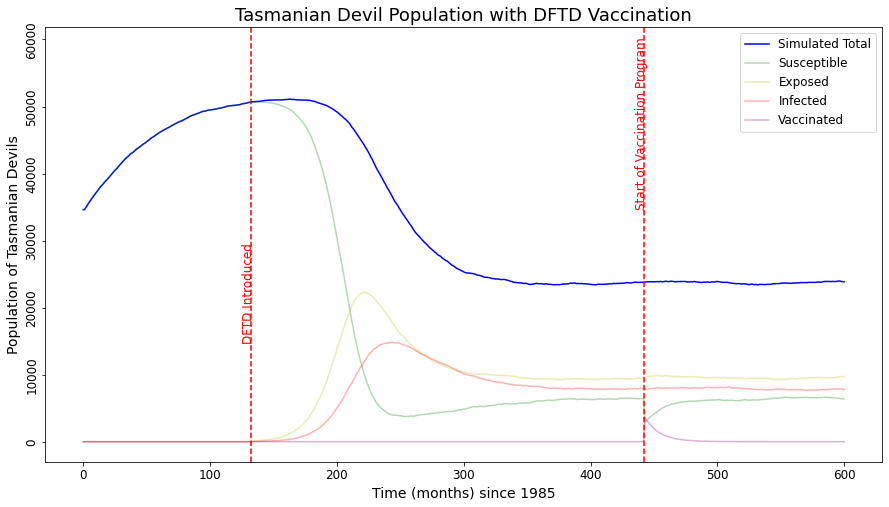

In [8]:
run_model()

## Configure Solver Widgets

In [24]:
def display_details():
    print('='*100)
    print('|', 'Input Parameters:'.ljust(96), '|')
    print('|', f'\tVaccinated Infection Rate: {variables["vaccinated_infection_rate"]}'.ljust(43), end='')
    print(f'Vaccination Proportion: {variables["vaccination_proportion"]}'.ljust(48), '|')
    print('|', f'\tVaccine Frequency: {variables["vaccine_frequency"]}'.ljust(43), end='')
    print(f'Vaccine Time: {variables["vaccine_time"]}'.ljust(48), '|')
    print('|', f'\tProgram Length: {variables["program_length"]}'.ljust(91), '|')
    print('='*100)

In [20]:
def configure(vaccinated_infection_rate, vaccination_proportion, vaccine_frequency, vaccine_time, program_length):
    variables['vaccinated_infection_rate'] = str(vaccinated_infection_rate)
    variables['vaccination_proportion'] = str(vaccination_proportion)
    variables['vaccine_frequency'] = str(vaccine_frequency)
    variables['vaccine_time'] = str(vaccine_time)
    variables['program_length'] = str(program_length)
    
    display_details()
    run_model()

## Create Widgets

In [25]:
ai_widgets = {
    "vaccinated_infection_rate": widgets.FloatSlider(
        min=0.1, max=2, step=0.1, value=variables['vaccinated_infection_rate'], description=" "
    ),
    "vaccination_proportion": widgets.FloatSlider(
        min=0.12, max=1.2, step=0.01, value=variables['vaccination_proportion'], description=" "
    ),
    "vaccine_frequency": widgets.IntSlider(
        min=1, max=12, step=1, value=variables['vaccine_frequency'], description=" "
    ),
    "vaccine_time": widgets.IntSlider(
        min=0, max=36, step=1, value=variables['vaccine_time'], description=" "
    ),
    "program_length": widgets.IntSlider(
        min=1, max=10, step=1, value=variables['program_length'], description=" "
    ),
}

In [22]:
layout = widgets.Layout(width='150px')
uis = [
    widgets.HBox(
        [widgets.Label("Vaccinated Infection Rate", layout=layout), ai_widgets['vaccinated_infection_rate']]
    ),
    widgets.HBox(
        [widgets.Label("Vaccination Proportion", layout=layout), ai_widgets['vaccination_proportion']]
    ),
    widgets.HBox(
        [widgets.Label("Vaccine Frequency", layout=layout), ai_widgets['vaccine_frequency']]
    ),
    widgets.HBox(
        [widgets.Label("Vaccine Time", layout=layout), ai_widgets['vaccine_time']]
    ),
    widgets.HBox(
        [widgets.Label("Program Length", layout=layout), ai_widgets['program_length']]
    )
]

## Run widgets and attempt to calibrate model

In [32]:
out = interactive_output(configure, ai_widgets)
display(*uis, out)

Output()

## Export model as StochSS Model (.mdl)

In [ ]:
stochss_mdl = export_StochSS(DevilsDFTDVaccination(values=variables), return_stochss_model=True)
class NumpyEncoder(json.JSONEncoder):
    def default(self, o):
        if isinstance(o, np.ndarray):
            return o.tolist()
        if isinstance(o, np.int64):
            return int(o)
        return json.JSONEncoder.default(self, o)
with open("Devils Vaccination.mdl", "w") as mdl_file:
    json.dump(stochss_mdl, mdl_file, indent=4, sort_keys=True, cls=NumpyEncoder)